In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
from pytorchtools import EarlyStopping #from https://github.com/Bjarten/early-stopping-pytorch
import os
from random import randint
import zipfile
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


#Following code modified from https://github.com/kennethleungty/PyTorch-Ignite-Tiny-ImageNet-Classification

In [2]:
#set random seed
random_seed = 100
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

nepoch = 10000
early_stop = False
Patience = 15

In [3]:
# # Retrieve data directly from Stanford data source
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [4]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset using ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 2}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

In [5]:
# Unlike training folder where images are already arranged in sub folders based 
# on their labels, images in validation folder are all inside a single folder. 
# Validation folder comes with images folder and val_annotations txt file. 
# The val_annotation txt file comprises 6 tab separated columns of filename, 
# class label, x and y coordinates, height, and width of bounding boxes
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [6]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')


# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [7]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [8]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [9]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])
train_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.RandomRotation(20),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 
])


val_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 
])

In [10]:
# Define batch size for data loaders
batch_size = 64

train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=train_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


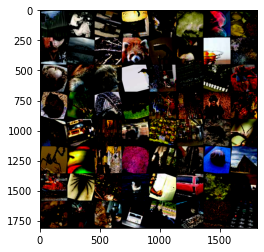

In [11]:
# Display batch of training set images
show_batch(train_loader)

In [12]:
# Create dataloaders for validation data
val_loader = generate_dataloader(val_img_dir, "val",
                                 transform=val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


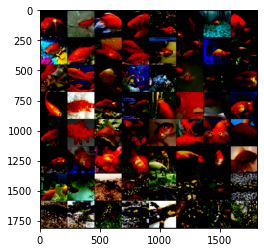

In [13]:
# Display batch of validation images
show_batch(val_loader)

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()   
images.shape

torch.Size([64, 3, 224, 224])

In [15]:
from models import *
model = ResNet18()  
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5,betas=(0.99, 0.9999))

Let's use 4 GPUs!


In [ ]:
from datetime import datetime

train_loss = []
test_loss = []
train_acc = []
test_acc = []

early_stopping = EarlyStopping(patience= Patience, verbose=True)

for epoch in range(nepoch): 
    
    start = datetime.now()
    
    print(f"Epoch {epoch}")
    
    #training
    model.train()  

    train_loss_total = 0
    correct_train = 0
    
    for i, data in enumerate(train_loader, 0):
        

        inputs, labels = data[0].to(device), data[1].to(device)        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_total += outputs.shape[0] * loss.item()
        pred = outputs.argmax(dim=1, keepdim=True) 
        correct_train += pred.eq(labels.view_as(pred)).sum().item()
    train_loss_epoch = train_loss_total / len(train_loader.dataset)
    train_acc_epoch = 100. * correct_train / len(train_loader.dataset)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss_epoch, correct_train, len(train_loader.dataset),train_acc_epoch
        ))
    
    #testing
    model.eval()
    
    test_loss_total = 0
    correct_test = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss_test = criterion(outputs, labels)
            test_loss_total += outputs.shape[0] * loss_test.item()
            pred = outputs.argmax(dim=1, keepdim=True)  
            correct_test += pred.eq(labels.view_as(pred)).sum().item()

    test_loss_epoch = test_loss_total/ len(val_loader.dataset)
    test_acc_epoch = 100. * correct_test / len(val_loader.dataset)
    test_loss.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_epoch, correct_test, len(val_loader.dataset),
        test_acc_epoch))
    
    elapsed_time =  datetime.now() - start
    print(f"{elapsed_time.total_seconds()} seconds")
    
    if early_stop:
        early_stopping(test_loss_epoch, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


if early_stopping:
    model.load_state_dict(torch.load('checkpoint.pt'))

Epoch 0
Train set: Average loss: 4.8824, Accuracy: 4910/100000 (5%)
Test set: Average loss: 4.6471, Accuracy: 736/10000 (7%)
142.911093 seconds
Epoch 1
Train set: Average loss: 4.5742, Accuracy: 8422/100000 (8%)
Test set: Average loss: 4.3811, Accuracy: 1069/10000 (11%)
133.432458 seconds
Epoch 2
Train set: Average loss: 4.3776, Accuracy: 10973/100000 (11%)
Test set: Average loss: 4.1982, Accuracy: 1303/10000 (13%)
133.373451 seconds
Epoch 3
Train set: Average loss: 4.2113, Accuracy: 13343/100000 (13%)
Test set: Average loss: 4.0480, Accuracy: 1503/10000 (15%)
133.041669 seconds
Epoch 4
Train set: Average loss: 4.0772, Accuracy: 15044/100000 (15%)
Test set: Average loss: 3.9054, Accuracy: 1708/10000 (17%)
133.277253 seconds
Epoch 5
Train set: Average loss: 3.9722, Accuracy: 16721/100000 (17%)
Test set: Average loss: 3.8082, Accuracy: 1794/10000 (18%)
133.366678 seconds
Epoch 6
Train set: Average loss: 3.8713, Accuracy: 18013/100000 (18%)
Test set: Average loss: 3.7012, Accuracy: 1959/1

Test set: Average loss: 2.3598, Accuracy: 4404/10000 (44%)
133.825116 seconds
Epoch 56
Train set: Average loss: 2.2605, Accuracy: 47222/100000 (47%)
Test set: Average loss: 2.3385, Accuracy: 4432/10000 (44%)
133.616666 seconds
Epoch 57
Train set: Average loss: 2.2379, Accuracy: 47521/100000 (48%)
Test set: Average loss: 2.3325, Accuracy: 4429/10000 (44%)
133.879563 seconds
Epoch 58
Train set: Average loss: 2.2248, Accuracy: 47910/100000 (48%)
Test set: Average loss: 2.3312, Accuracy: 4491/10000 (45%)
134.135296 seconds
Epoch 59
Train set: Average loss: 2.2115, Accuracy: 48065/100000 (48%)
Test set: Average loss: 2.3132, Accuracy: 4458/10000 (45%)
133.323217 seconds
Epoch 60
Train set: Average loss: 2.1914, Accuracy: 48628/100000 (49%)
Test set: Average loss: 2.3114, Accuracy: 4483/10000 (45%)
133.807404 seconds
Epoch 61
Train set: Average loss: 2.1788, Accuracy: 48811/100000 (49%)
Test set: Average loss: 2.2923, Accuracy: 4531/10000 (45%)
133.844285 seconds
Epoch 62
Train set: Average 

Test set: Average loss: 2.0701, Accuracy: 5007/10000 (50%)
133.802155 seconds
Epoch 111
Train set: Average loss: 1.5387, Accuracy: 62939/100000 (63%)
Test set: Average loss: 2.0593, Accuracy: 5037/10000 (50%)
133.548502 seconds
Epoch 112
Train set: Average loss: 1.5274, Accuracy: 63119/100000 (63%)
Test set: Average loss: 2.0669, Accuracy: 5069/10000 (51%)
133.982061 seconds
Epoch 113
Train set: Average loss: 1.5174, Accuracy: 63357/100000 (63%)
Test set: Average loss: 2.0398, Accuracy: 5105/10000 (51%)
133.844982 seconds
Epoch 114
Train set: Average loss: 1.5093, Accuracy: 63578/100000 (64%)
Test set: Average loss: 2.0516, Accuracy: 5103/10000 (51%)
133.219725 seconds
Epoch 115
Train set: Average loss: 1.4955, Accuracy: 63844/100000 (64%)
Test set: Average loss: 2.0551, Accuracy: 5072/10000 (51%)
133.795418 seconds
Epoch 116
Train set: Average loss: 1.4811, Accuracy: 64329/100000 (64%)
Test set: Average loss: 2.0766, Accuracy: 5022/10000 (50%)
134.039028 seconds
Epoch 117
Train set: A

Test set: Average loss: 2.0788, Accuracy: 5150/10000 (52%)
133.754055 seconds
Epoch 166
Train set: Average loss: 1.0081, Accuracy: 76033/100000 (76%)
Test set: Average loss: 2.0696, Accuracy: 5155/10000 (52%)
133.577646 seconds
Epoch 167
Train set: Average loss: 0.9942, Accuracy: 76421/100000 (76%)
Test set: Average loss: 2.0848, Accuracy: 5102/10000 (51%)
133.942298 seconds
Epoch 168
Train set: Average loss: 0.9901, Accuracy: 76410/100000 (76%)
Test set: Average loss: 2.0951, Accuracy: 5114/10000 (51%)
133.869892 seconds
Epoch 169
Train set: Average loss: 0.9823, Accuracy: 76708/100000 (77%)
Test set: Average loss: 2.0719, Accuracy: 5211/10000 (52%)
133.8849 seconds
Epoch 170
Train set: Average loss: 0.9710, Accuracy: 76899/100000 (77%)
Test set: Average loss: 2.1236, Accuracy: 5085/10000 (51%)
133.716451 seconds
Epoch 171
Train set: Average loss: 0.9651, Accuracy: 77065/100000 (77%)
Test set: Average loss: 2.0633, Accuracy: 5184/10000 (52%)
133.819592 seconds
Epoch 172
Train set: Ave

Test set: Average loss: 2.1876, Accuracy: 5133/10000 (51%)
134.109421 seconds
Epoch 221
Train set: Average loss: 0.5982, Accuracy: 86959/100000 (87%)
Test set: Average loss: 2.2229, Accuracy: 5077/10000 (51%)
133.627034 seconds
Epoch 222
Train set: Average loss: 0.5921, Accuracy: 87050/100000 (87%)
Test set: Average loss: 2.1833, Accuracy: 5141/10000 (51%)
133.898607 seconds
Epoch 223
Train set: Average loss: 0.5850, Accuracy: 87298/100000 (87%)
Test set: Average loss: 2.2135, Accuracy: 5145/10000 (51%)
134.026261 seconds
Epoch 224
Train set: Average loss: 0.5808, Accuracy: 87333/100000 (87%)
Test set: Average loss: 2.2310, Accuracy: 5111/10000 (51%)
134.094143 seconds
Epoch 225
Train set: Average loss: 0.5705, Accuracy: 87680/100000 (88%)
Test set: Average loss: 2.2057, Accuracy: 5120/10000 (51%)
133.86984 seconds
Epoch 226
Train set: Average loss: 0.5704, Accuracy: 87668/100000 (88%)
Test set: Average loss: 2.2298, Accuracy: 5099/10000 (51%)
133.819694 seconds
Epoch 227
Train set: Av

Test set: Average loss: 2.4242, Accuracy: 5001/10000 (50%)
133.689448 seconds
Epoch 276
Train set: Average loss: 0.3319, Accuracy: 93835/100000 (94%)
Test set: Average loss: 2.3779, Accuracy: 5060/10000 (51%)
134.020349 seconds
Epoch 277
Train set: Average loss: 0.3226, Accuracy: 94118/100000 (94%)
Test set: Average loss: 2.3885, Accuracy: 5047/10000 (50%)
134.103823 seconds
Epoch 278
Train set: Average loss: 0.3175, Accuracy: 94275/100000 (94%)
Test set: Average loss: 2.3972, Accuracy: 5054/10000 (51%)
133.648136 seconds
Epoch 279
Train set: Average loss: 0.3123, Accuracy: 94437/100000 (94%)
Test set: Average loss: 2.3842, Accuracy: 5025/10000 (50%)
134.044272 seconds
Epoch 280
Train set: Average loss: 0.3120, Accuracy: 94426/100000 (94%)
Test set: Average loss: 2.3992, Accuracy: 5063/10000 (51%)
133.940859 seconds
Epoch 281
Train set: Average loss: 0.3087, Accuracy: 94485/100000 (94%)
Test set: Average loss: 2.4085, Accuracy: 5015/10000 (50%)
133.877182 seconds
Epoch 282
Train set: A

Test set: Average loss: 2.5676, Accuracy: 4978/10000 (50%)
133.571934 seconds
Epoch 331
Train set: Average loss: 0.1864, Accuracy: 97076/100000 (97%)
Test set: Average loss: 2.5872, Accuracy: 4943/10000 (49%)
133.87609 seconds
Epoch 332
Train set: Average loss: 0.1831, Accuracy: 97153/100000 (97%)
Test set: Average loss: 2.5704, Accuracy: 4986/10000 (50%)
134.004414 seconds
Epoch 333
Train set: Average loss: 0.1852, Accuracy: 97100/100000 (97%)
Test set: Average loss: 2.5797, Accuracy: 4993/10000 (50%)
133.89601 seconds
Epoch 334
Train set: Average loss: 0.1795, Accuracy: 97226/100000 (97%)
Test set: Average loss: 2.5692, Accuracy: 5053/10000 (51%)
133.331616 seconds
Epoch 335
Train set: Average loss: 0.1761, Accuracy: 97370/100000 (97%)
Test set: Average loss: 2.5983, Accuracy: 4935/10000 (49%)
133.435424 seconds
Epoch 336
Train set: Average loss: 0.1763, Accuracy: 97273/100000 (97%)
Test set: Average loss: 2.5993, Accuracy: 4927/10000 (49%)
133.530149 seconds
Epoch 337
Train set: Ave

Test set: Average loss: 2.7470, Accuracy: 4915/10000 (49%)
133.442202 seconds
Epoch 386
Train set: Average loss: 0.1178, Accuracy: 98251/100000 (98%)
Test set: Average loss: 2.7743, Accuracy: 4873/10000 (49%)
133.972696 seconds
Epoch 387
Train set: Average loss: 0.1158, Accuracy: 98306/100000 (98%)
Test set: Average loss: 2.7530, Accuracy: 4987/10000 (50%)
134.372744 seconds
Epoch 388
Train set: Average loss: 0.1165, Accuracy: 98315/100000 (98%)
Test set: Average loss: 2.7480, Accuracy: 4920/10000 (49%)
133.81431 seconds
Epoch 389
Train set: Average loss: 0.1184, Accuracy: 98197/100000 (98%)
Test set: Average loss: 2.7508, Accuracy: 4949/10000 (49%)
133.989737 seconds
Epoch 390
Train set: Average loss: 0.1092, Accuracy: 98508/100000 (99%)
Test set: Average loss: 2.7306, Accuracy: 4980/10000 (50%)
133.733362 seconds
Epoch 391
Train set: Average loss: 0.1095, Accuracy: 98450/100000 (98%)
Test set: Average loss: 2.7666, Accuracy: 4932/10000 (49%)
133.778456 seconds
Epoch 392
Train set: Av

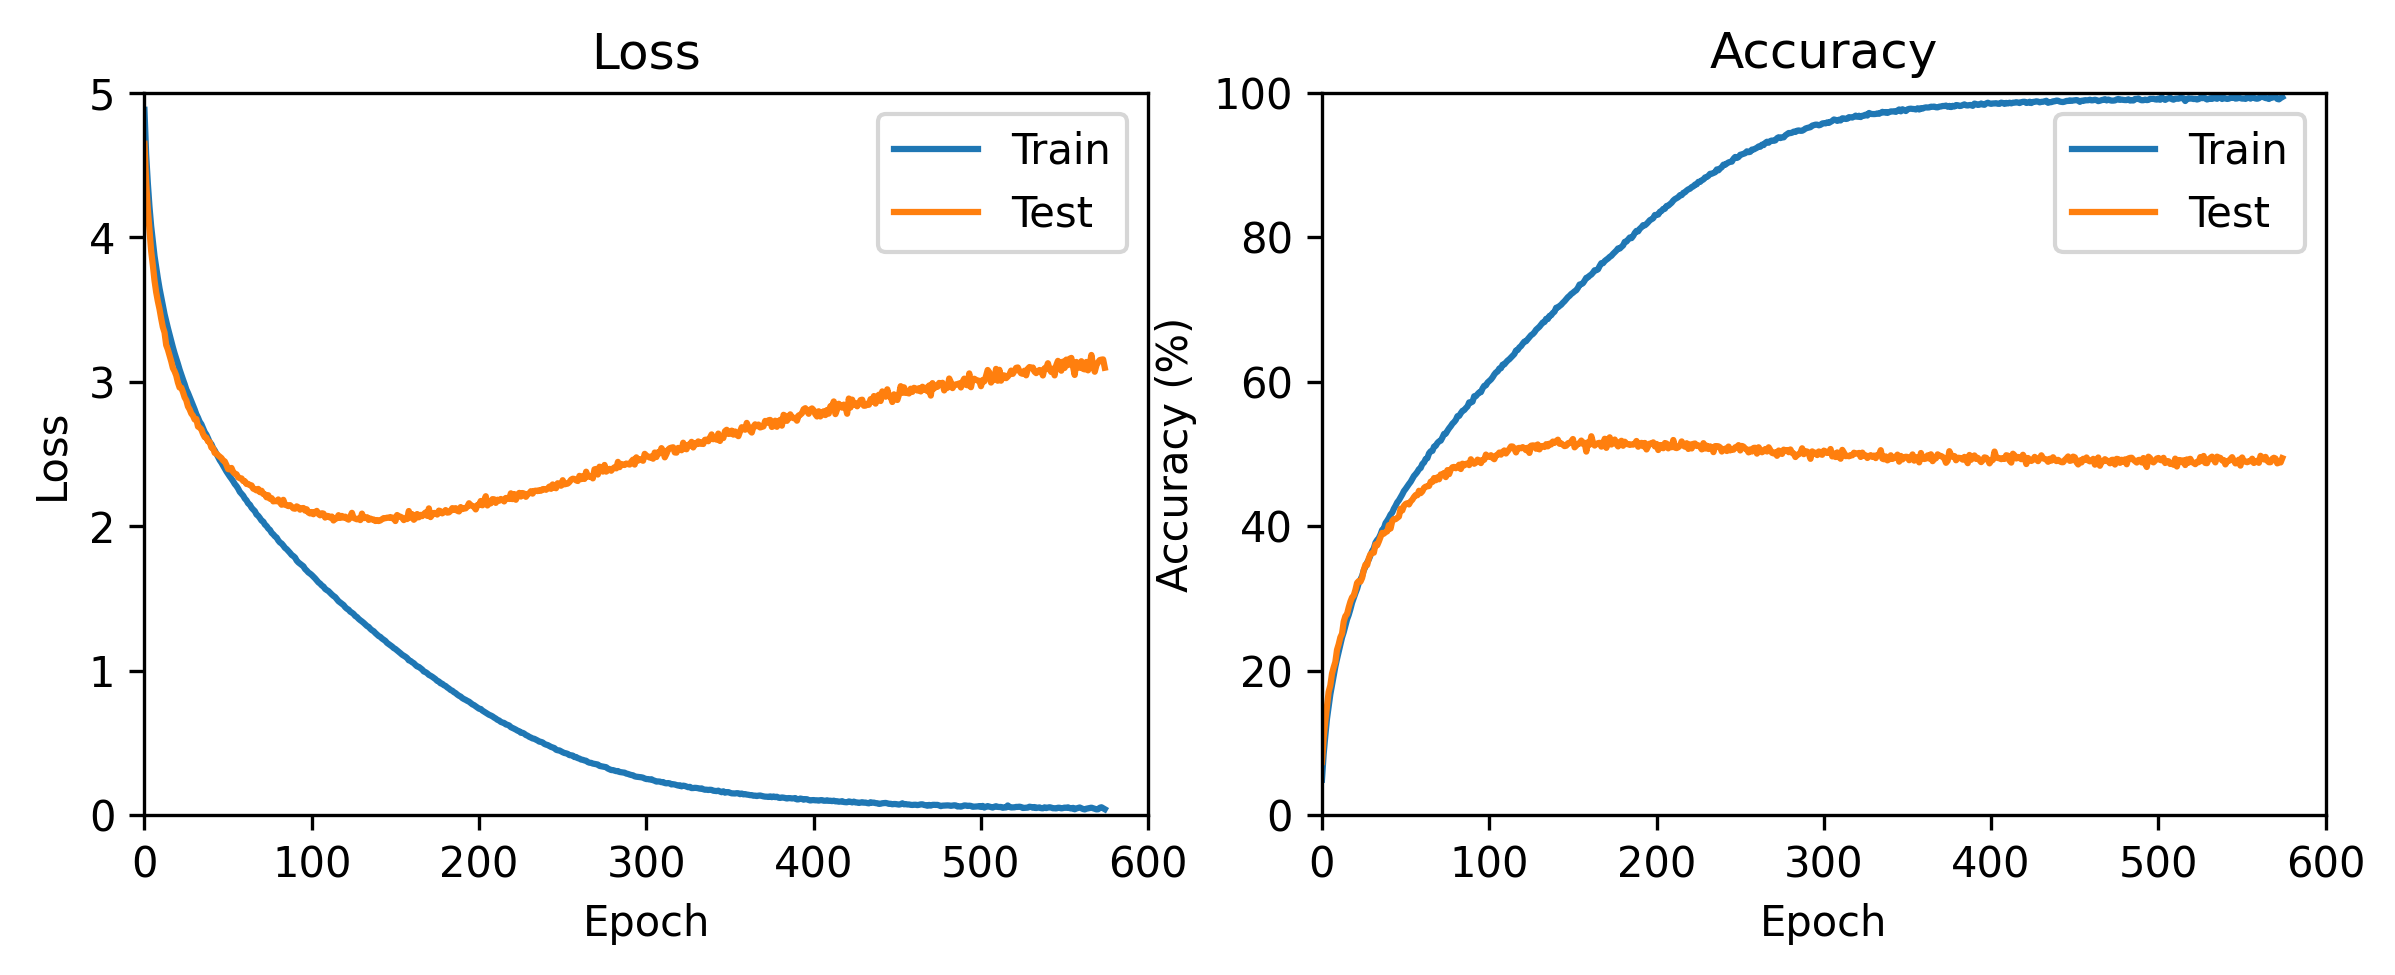

In [23]:
fig, axs = plt.subplots(1, 2,figsize = (8,3),dpi =300)

fig.tight_layout() 
axs[0].plot(train_loss,label = 'Train')
axs[0].plot(test_loss,label = 'Test')
axs[0].set_title('Loss')
axs[0].set_ylim(0,5)
axs[0].set_xlim(0,600)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(train_acc,label = 'Train')
axs[1].plot(test_acc,label = 'Test')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_xlim(0,600)
axs[1].set_ylim(0,100)
axs[1].legend()